Objective
------------------------

Investigate the effect of countermeasures / lockdown on mobility data. 


Assumptions
--------------------

- Assume that mobility is affected by weather, lockdown
- Assume mobility follows a weekly pattern (people tend to spend less time in parks Mo-Fr for example). Exploit assumptions about human routines here
- Consider every day independent of one another

Methodology
----------------------------------

Consider

- Derive features for weather (initially consider simply the median temperature)
- Lockdown index (some number)
- Mobility value
- is_weekend (boolean)


Data used
----------

* Oxford Stringency Index - https://github.com/OxCGRT/covid-policy-tracker

* Apple Transit mobility - https://covid19.apple.com/mobility

* Berlin air temperature - https://mesonet.agron.iastate.edu/ASOS/


Steps taken
---

* Prepare the dataset. Consolidate above mentioned data into a single dataframe

* Carry out causal inference analysis by carrying out the following four steps:
    - Model
    - Identify
    - Estimate
    - Refute

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from functools import reduce
import requests

%matplotlib inline
try:
    import graphviz
except:
    !pip install graphviz
    import graphviz
try:
    import pydotplus
except:
    !pip install pydotplus
    
from IPython.display import display
import networkx as nx
try:
    import pydot
except:
    !pip install pydot
try:
    from dowhy import CausalModel
except:
    #!pip install sympy
    !pip install -I dowhy
    from dowhy import CausalModel

**Data preparations**

Consolidate above mentioned data into a single dataframe

In [2]:
from project_lib import Project
project = Project.access()
Oxford_Stringency_Index_credentials = project.get_connected_data(name="Oxford Stringency Index")

import dsx_core_utils, os, io
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy

sqla_url= "db2+ibm_db://" + Oxford_Stringency_Index_credentials['username']+ ':' + Oxford_Stringency_Index_credentials['password'] + "@"+ Oxford_Stringency_Index_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
engine = create_engine(sqla_url, pool_size=10, max_overflow=20)
conn = engine.connect()

In [ ]:
# Transit mobility

project = Project.access()
Apple_transit_mobility_credentials = project.get_connected_data(name="Apple Transit Mobility")

apple_sqla_url= "db2+ibm_db://" + Apple_transit_mobility_credentials['username']+ ':' + Apple_transit_mobility_credentials['password'] + "@"+ Apple_transit_mobility_credentials['host'] + ":50001/BLUDB;Security=ssl;"

apple_engine = create_engine(apple_sqla_url, pool_size=10, max_overflow=20)
apple_conn = apple_engine.connect()

app_mob_df = pd.read_sql_table(Apple_transit_mobility_credentials['datapath'].split("/")[-1].lower(), apple_conn,index_col=['Timestamp'])
be_app_trans_df = app_mob_df[app_mob_df.region=='Berlin']
be_app_trans_df.drop(columns=['region'],inplace=True)

# Stringency
ox_df = pd.read_sql_table("oxford_stringency_index", conn)
ox_df["date"] = pd.to_datetime(ox_df["date"],format="%Y%m%d")

be_ox_df = ox_df[ox_df.countrycode=="DEU"]
be_ox_df.index= be_ox_df['date']
be_ox_df = be_ox_df[['stringencyindex']]
be_ox_df.rename({'stringencyindex':'lockdown'},axis=1,inplace=True)

# Berlin air temperature
r=requests.get('https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=EDDB&data=tmpc&year1=2020&month1=1&day1=1&year2=2020&month2=12&day2=7&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2')
df_airtemp_be = pd.read_csv(io.BytesIO(r.content))
df_airtemp_be.index = pd.to_datetime(df_airtemp_be['valid'].values)
df_airtemp_be.drop(['station','valid'],axis=1,inplace=True)
df_airtemp_be = df_airtemp_be.resample('1D').median()
df_airtemp_be.rename({'tmpc':'air_temperature'},axis=1,inplace=True)

dfs = [be_ox_df,be_app_trans_df,df_airtemp_be]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs)

df_final['is_weekend'] = np.where((df_final.index.weekday == 5)|(df_final.index.weekday == 6),1,0)

In [19]:
df_final.tail()

,lockdown,mobility,air_temperature,is_weekend
2020-12-02,67.59,61.28,-2.0,0
2020-12-03,67.59,62.63,-1.0,0
2020-12-04,67.59,66.25,1.0,0
2020-12-05,67.59,66.09,2.0,1
2020-12-06,67.59,56.03,8.0,1


In [20]:
df_final = df_final[df_final.index <=datetime.datetime(2020,9,15)]

**Causal inference analysis**

We construct a causal graph as shown below to test our hypothesis that includes all our assumptions

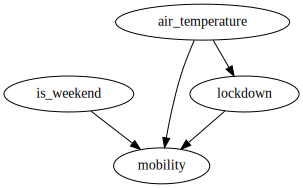

In [21]:
causal_graph = nx.DiGraph()
causal_graph.add_edge('is_weekend','mobility')
causal_graph.add_edge('lockdown','mobility')
causal_graph.add_edge('air_temperature','lockdown')
causal_graph.add_edge('air_temperature','mobility')

graph_filename='causal_mobility_weather.dot'
nx.drawing.nx_pydot.write_dot(causal_graph,graph_filename)

with open(graph_filename) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

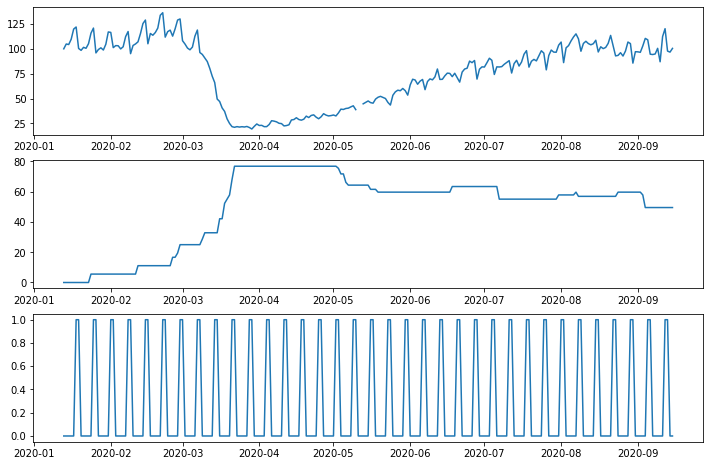

In [22]:
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axs[0].plot(df_final['mobility'])
axs[1].plot(df_final['lockdown'])
axs[2].plot(df_final['is_weekend'])

Why do I think day information is good? Looking at the graph above, it suggests that there is a strong periodic component in the mobility info. 
Let me plot the Power Spectral Density and check if there is any kind of periodicity in the data.

<StemContainer object of 3 artists>

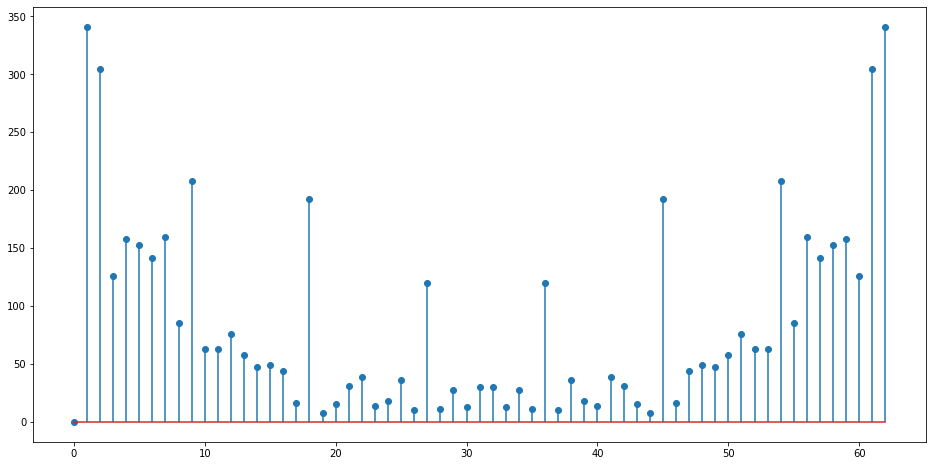

In [26]:
plt.figure(figsize=(16,8))
plt.stem(np.abs(np.fft.fft(df_final[df_final.index<=pd.to_datetime('2020-03-15')]['mobility'].values-np.mean(df_final[df_final.index<=pd.to_datetime('2020-03-15')]['mobility'].values))))

The following three steps are carried out:

* Model - we feed in the data and the causal graph constructed using our assumptions to create a causal model

* Identify - Use the created causal model to identify causal effect

* Estimate - Estimate the causal effect using the estimand and one of the supported estimation methods

In [27]:
model = CausalModel(data=df_final.dropna().reset_index(drop=True),treatment=['lockdown'],outcome='mobility',instruments=[],graph=graph_filename,proceed_when_unidentifiable=True)
print(model)

estimand = model.identify_effect()
print(estimand)

estimate = model.estimate_effect(estimand,method_name='backdoor1.linear_regression',test_significance=True)
print(estimate)


ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: mobility~lockdown+air_temperature+is_weekend+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|air_temperature,is_weekend))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,is_weekend,U) = P(mobility|lockdown,air_temperature,is_weekend)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Id

**Refute the estimate**

Refutation methods help in validating the causal effect estimate

Placebo Treatment: 

What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)

In [28]:
ref = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='placebo_treatment_refuter')
print(ref)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zer

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~plac

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Line

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+air_temperature+is_weekend+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

Refute: Use a Placebo Treatment
Estimated effect:-1.34105907865316
New effect:0.0
p value:1.0



Add Random Common Cause: 

Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [29]:
ref = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='random_common_cause')
print(ref)

INFO:dowhy.causal_estimator:b: mobility~lockdown+air_temperature+is_weekend+w_random+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:-1.34105907865316
New effect:-1.3417926512875624



**Observation**

* The results of random common cause refuter shows that the causal model is robust

* The linear regression model estimated by the causal estimator can be used to build a mobility estimator

**Author**

* Shri Nishanth Rajendran - AI Development Specialist, R² Data Labs, Rolls Royce

This notebook is based on the work done by Deepak Srinivasan

Special thanks to Deepak Srinivasan and Alvaro Corrales Cano